In [2]:
!pip install pymysql

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#@title IMPORTS
import math
import torch
import torch.nn as nn
import logging
import torch.nn.functional as F
import numpy as np
from torch import Tensor
#from time import time
import time
from matplotlib import pyplot
#from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import pandas as pd
import random
import datetime
import pymysql
import requests
import json
import os
import sqlite3
import pymysql
from joblib import dump
import math
import torch
import torch.nn as nn
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from joblib import load
from torch.utils.data.dataset import Subset


# import Table as module
from sklearn.model_selection import train_test_split
from torch import Tensor
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler

In [29]:
#@title config
config = {
    "alpha_vantage": {
        "key": "YOUR_API_KEY", # Claim your free API key here: https://www.alphavantage.co/support/#api-key
        "symbol": "IBM",
        "outputsize": "full",
        "key_adjusted_close": "5. adjusted close",
    },
    "data": {
        "window_size": 20,
        "train_split_size": 0.80
    },
    "plots": {
        "xticks_interval": 10, # show a date every 90 days
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "model": {
        "device": torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
        "embed_dim" :512,
        "nheads": 16,
        "nlayers": 1,
        "dropout": 0.1,
        "input_size": 100,
        "batch_first": False,
        "d_model": 256,  
        "num_encoder_layers": 4,
        "num_decoder_layers": 2,
        "num_heads": 8,
        "dropout_encoder": 0.2, 
        "dropout_decoder": 0.2,
        "dim_feedforward_encoder": 2048,
        "dim_feedforward_decoder": 2048,
        "num_predicted_features": 1
    },
    "training": {
        "batch_size": 32,
        "shuffle" : True,
        "drop_last": True,
        "num_workers": 0,

    }
}

In [5]:
#@title REQUESTS
url_fin_maa = "https://financialmodelingprep.com/api/v4/mergers-acquisitions-rss-feed?page=0&apikey=97f0aa24a2135e44b837816823899d77"
# Company Enterprise Value
url_fin_kpi = "https://financialmodelingprep.com/api/v3/enterprise-values/AAPL?apikey=97f0aa24a2135e44b837816823899d77"
url_fin_symbol = "https://financialmodelingprep.com/api/v3/available-traded/list?apikey=97f0aa24a2135e44b837816823899d77"

# SYMBOL | Name ...
def api_request_symbol() -> list:  # Returns list of dictionaries received from API
    try:
        response = requests.get(url_fin_symbol)
        if response.status_code == 200:
            print("Connection to symbol-API successful")
            return response.json()
    except Exception as e:
        print("maa-API Error")


symbol_data = api_request_symbol()
df_symbol = pd.DataFrame(symbol_data)
#df_symbol.head()
#df_symbol.info()


def api_request_maa() -> list:  # Returns list of dictionaries received from API
    try:
        response = requests.get(url_fin_maa)
        if response.status_code == 200:
            print("Connection to maa-API successful")
            return response.json()
    except Exception as e:
        print("maa-API Error")


def api_request_kpi() -> list:  # Returns list of dictionaries received from API
    try:
        response = requests.get(url_fin_kpi)
        if response.status_code == 200:
            print("Connection to kpi-API successful")
            return response.json()
    except Exception as e:
        print("kpi-API Error")


maa_secData = api_request_maa()
# kpi_data = api_request_kpi()

keys_maa = [
    "companyName",
    "targetedCompanyName",
    "transactionDate",
]  # Keys of interest for dictionary data
keys_kpi = ""


Connection to symbol-API successful
Connection to maa-API successful


In [6]:
#@title TABLE
db_name = "maaDB"

def dbconnect():
    try:
        db = pymysql.connect(
            host="database-1.cqnkqcoyeu6x.eu-west-2.rds.amazonaws.com",
            user="admin",
            password="123456789",
        )
    except Exception as e:
        print("Can't connect to database")
    return db


class Table:
    db_name = "maaDB"
    db = pymysql.connect(
        host="database-1.cqnkqcoyeu6x.eu-west-2.rds.amazonaws.com",
        user="admin",
        password="123456789",
    )

    def dbconnect():
        try:
            db = pymysql.connect(
                host="database-1.cqnkqcoyeu6x.eu-west-2.rds.amazonaws.com",
                user="admin",
                password="123456789",
            )
        except Exception as e:
            print("Can't connect to database")
        return db

    def __init__(self, table_name: str, columns: dict):
        self.table_name = table_name
        self.columns = columns

    def create_table(self) -> None:
        try:
            db = dbconnect()
            cursor = db.cursor()
            cursor.execute("USE {db_name}".format(db_name=db_name))
            cursor.execute(f"CREATE DATABASE IF NOT EXISTS {db_name}")
            sql = """CREATE TABLE {table_name} (
                 ID int NOT NULL AUTO_INCREMENT""".format(
                table_name=self.table_name
            )
            for key in self.columns:
                sql = sql + ", " + str(key) + " " + str(self.columns.get(key))
            sql = sql + ",PRIMARY KEY (ID) )"
            cursor.execute(sql)
            db.commit()
            cursor.close()
            print("Table Created")

        except Exception as e:
            print(e)

    @staticmethod
    def check_tables() -> tuple:
        db = dbconnect()
        cursor = db.cursor()
        cursor.execute("USE {db_name}".format(db_name=db_name))
        sql = "SHOW TABLES"
        cursor.execute(sql)
        return cursor.fetchall()

    def show_table_entries(self) -> None:
        db = dbconnect()
        cursor = db.cursor()
        cursor.execute("USE {db_name}".format(db_name=db_name))
        sql = "SELECT * FROM {table_name}".format(table_name=self.table_name)
        cursor.execute(sql)
        result = cursor.fetchall()
        print("Total rows are: ", len(result))
        # print(result)
        cursor.close()
        return result

    # COUNT NUMBER OF ENTIRES IN TABLE
    def count_table_index(self) -> int:
        try:
            db = dbconnect()
            cursor = db.cursor()
            cursor.execute("USE {db_name}".format(db_name=db_name))
            sql = "SELECT COUNT ('ID') FROM {table_name}".format(
                table_name=self.table_name
            )
            cursor.execute(sql)
            count = cursor.fetchall()
            return int(count)

        except Exception as e:
            print(e)

    # DELETE ENTRY FROM TABLE
    # MAYBE PUT CONDITION INSTEAD OF ID LIKE WHERE CustomerName="Alfreds Futterkiste"
    def delete_from_table(self, condition: str) -> None:
        try:
            db = dbconnect()
            cursor = db.cursor()
            cursor.execute("USE maaDB")
            sql = "DELETE FROM {table_name} WHERE {condition}".format(
                table_name=self.table_name, condition=condition
            )
            cursor.execute(sql)
            db.commit()
            cursor.close()
            print("Deletion completed!")
        except Exception as e:
            print(e)

    def add_columns(self, columns: dict) -> None:  # CHANGE self.columns with append
        try:
            db = dbconnect()
            cursor = db.cursor()
            cursor.execute("USE {db_name}".format(db_name=db_name))
            sql = "ALTER TABLE {table_name}".format(table_name=self.table_name)
            for key in columns:
                sql = (
                    sql + " ADD COLUMN " + str(key) + " " + str(columns.get(key)) + ","
                )
            cursor.execute(sql)
            cursor.close()
            db.commit()
            self.columns = self.columns.update(columns)
            print("Columns added successfully")

        except Exception as e:
            print(e)

    def insert_db(self, columns: dict, values: list) -> None:
        try:
            db = dbconnect()
            cursor = db.cursor()
            cursor.execute("USE {db_name}".format(db_name=db_name))
            if len(columns) == len(values):
                sql = "INSERT INTO {table_name} (".format(table_name=self.table_name)
                for key in columns:
                    sql = sql + str(key) + ", "
                sql = sql[:-2] + ") VALUES ("
                for value in values:
                    sql = sql + '"' + str(value) + '"' + ", "
                sql = sql[:-2] + ")"
                cursor.execute(sql)
                cursor.close()
                db.commit()
                print("Insertion completed.")
            else:
                print("Number of columns != number of values!")
        except Exception as e:
            print(e)

    def drop_table(self) -> None:
        try:
            db = dbconnect()
            cursor = db.cursor()
            cursor.execute("USE {db_name}".format(db_name=db_name))
            sql = "DROP TABLE {table_name}".format(table_name=self.table_name)
            cursor.execute(sql)
            cursor.close()
            db.commit()
            print(f"Table {self.table_name} dropped successfully!")
        except Exception as e:
            print(e)

    def table_to_pddf(self, columns_few: str) -> None:
        try:
            db = dbconnect()
            cursor = db.cursor()
            cursor.execute("USE {db_name}".format(db_name=db_name))
            sql = "SELECT {columns} FROM {table_name}".format(
                columns=columns_few, table_name=self.table_name
            )
            sql_query = pd.read_sql_query(sql, db)
            cursor.close()
            return pd.DataFrame(sql_query)
        except Exception as e:
            print(e)


In [ ]:
#@title insertion
company_names, start_dates, end_dates = list(df_clean.loc[:,"Parent Company"]),list(df_clean.loc[:, "start_dates"]),list(df_clean.loc[:, "end_dates"])

#GET START DATES 30 DAYS PRIOR AND END DATES 60 DAYS AFTER MAA DATE
start_dates = []
end_dates = []
for date in dates:
    start = date - datetime.timedelta(days=30)
    end = date + datetime.timedelta(days=120)
    start_dates.append(start)
    end_dates.append(end)
#RETRIEVE SERIES OF STOCK DATA
def get_stock_data(company_name:str, start:datetime.datetime, end:datetime.datetime) -> list[float]:
    ticker = tickers.get(company_name.lower())
    data = yf.download(ticker, start=start, end=end, interval="1d").iloc[:,1]
    #FILL IN MISSING DATES WITH NULL VALUE
    idx = pd.date_range(start, end)
    data.index = pd.DatetimeIndex(data.index)
    data = data.reindex(idx, fill_value= "NULL")
    return data      #MAYBE CHANGE TO LIST FOR CONTINUITY

#list(get_stock_data(company_names[2], start_dates[2], end_dates[2]))

columns_stock_data = {"ticker": "varchar(255)", "start_date":"date","end_date":"date"}
for i in range (0,151):
    columns_stock_data.update({"%id"%i:"float(24)"})
#stock_table.drop_table()
stock_table = Table("stock_table", columns_stock_data)
stock_table.create_table()
#print(columns_stock_data)
def insert_stock_data() -> None:
    for i in range(0,len(df_clean)):
        fin_data = list(get_stock_data(company_names[i],start_dates[i],end_dates[i]))
        values = [company_names[i], start_dates[i], end_dates[i]]
        values.extend(fin_data)
        stock_table.insert_db(columns_stock_data, values)
#stock_table.add_columns(columns_stock_data)
#insert_stock_data()
#STOCK DATA THAT IS MISSING FOR START AND END DATE IS AUTOMATICALLY DISMISSED
print("COMPLETE")





#list(get_stock_data(company_names[2], start_dates[2], end_dates[2]))
#GET START DATES 30 DAYS PRIOR AND END DATES 60 DAYS AFTER MAA DATE
start_dates = []
end_dates = []
for date in dates:
    start = date - datetime.timedelta(days=300)
    end = date + datetime.timedelta(days=150)
    start_dates.append(start)
    end_dates.append(end)
columns_stock_data = {"ticker": "varchar(255)", "start_date":"date","end_date":"date"}
for i in range (0,451):
    columns_stock_data.update({"%id"%i:"float(24)"})
#stock_table2.drop_table()
stock_table2 = Table("stock_table2", columns_stock_data)
stock_table2.create_table()
#print(columns_stock_data)
def insert_stock_data() -> None:
    for i in range(0,len(df_clean)):
        fin_data = list(get_stock_data(company_names[i],start_dates[i],end_dates[i]))
        values = [company_names[i], start_dates[i], end_dates[i]]
        values.extend(fin_data)
        stock_table2.insert_db(columns_stock_data, values)
#stock_table.add_columns(columns_stock_data)
insert_stock_data()
#STOCK DATA THAT IS MISSING FOR START AND END DATE IS AUTOMATICALLY DISMISSED
print("COMPLETE")


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:192: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


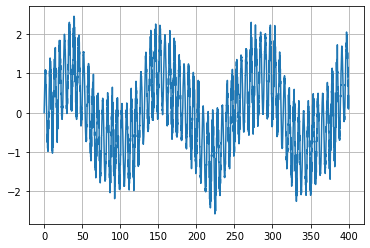

In [7]:
#@title DATA_PROCESSING
from joblib import dump
"""
FETCH DATA FROM SQL DATABASE
"""

# IF TICKER is NONE -> ALL TICKERS
def fetch_data(table_num: int, company: str) -> pd.DataFrame:
    try:
        db = pymysql.connect(
            host="database-1.cqnkqcoyeu6x.eu-west-2.rds.amazonaws.com",
            user="admin",
            password="123456789",
        )

    except Exception as e:
        print("Can not connect to database")

    columns = {"ticker": "varchar(255)", "start_date": "date", "end_date": "date"}
    columns_price = "0d"
    
    

    if table_num == 1 and company is None:
        table_name = "stock_table"
        for i in range(1, 150):
            columns_price += f", {i}d"
        sql = "SELECT DISTINCT {columns} FROM {table_name}".format(
            columns=columns_price, table_name=table_name
        )
    elif table_num == 2:
        table_name = "stock_table2"
        for i in range(1, 450):
            columns_price += f", {i}d"
        if company is None:
          sql = "SELECT DISTINCT {columns} FROM {table_name}".format(
              columns=columns_price, table_name=table_name
          )
        else:
          sql = """SELECT DISTINCT {columns} FROM {table_name}
                WHERE ticker = '{company}';""".format(
          columns=columns_price, table_name=table_name, company=company
      )




    cursor = db.cursor()
    cursor.execute("USE {db_name}".format(db_name=Table.db_name))

    sql_query = pd.read_sql_query(sql, db)
    return pd.DataFrame(sql_query)



def processed_data(table_num: int, company: str) -> Tensor:
    df = fetch_data(table_num, company)
    # FILL ZERO VALUES WITH VALUE BEFORE AND AFTER
    df_t = df.transpose()  # [150, TOTAL_SEQUENCES]
    df_t = df_t.replace(to_replace=0, method="ffill")
    df_t = df_t.replace(to_replace=0, method="bfill")
    # REMOVE RESIDUAL SEQUENCES CONTAINING 0'S
    # DELETE RESIDIUAL DATA
    df_t = df_t.loc[:, (df_t != 0).any(axis=0)]  # TOTAL SEQUENCES: 1396 -> 1299 
    return torch.tensor(df_t.values)  # CONVERT TO TENSOR | [SEQUECE_LENGTH, TOTAL_SEQUENCES]

"""
CREATE CUSTOM DATASET
"""


class StockPriceDataset(Dataset):
    def __init__(
        self, dataset: Tensor, device
    ) -> None:  # , training_length:int, forecast_window:int

        # self.T = training_length #var
        # self.S = forecast_window #120
        self.data = dataset
        #self.transform = MinMaxScaler(feature_range=(0, 1))
        self.transform = StandardScaler()
        self.device = device

    def __len__(self) -> int:

        return self.data.size()[1]

    def __getitem__(self, idx: int) -> Tensor:

        _input = self.data[:, idx]  # THE idx'TH  SEQUENCE
        scaler = self.transform
        scaler.fit(_input.unsqueeze(-1))

        # save the scalar to be used later when inverse translating the data for plotting.
        dump(scaler, "scalar_item.joblib")
        _input = torch.tensor(scaler.transform(_input.unsqueeze(-1))).squeeze(-1).to(
         device
        )
        return _input
        


"""
PLAIN INTO TRAIN AND TEST DATA
"""
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_test_ratio = 0.8
#[FULL_SEQUENCE, NUM_SEQUENCES]
#30PRI 120 AFTER
total_data_30_120 = processed_data(1, None)
full_stock_data_30_120 = StockPriceDataset(total_data_30_120, device)
train_size = int(train_test_ratio * len(full_stock_data_30_120))
test_size = len(full_stock_data_30_120) - train_size
train_dataset_30_120, test_dataset_30_120 = torch.utils.data.random_split(
    full_stock_data_30_120, [train_size, test_size]
)

#30 PRI 30 AFTER

total_data_30_30 = total_data_30_120[:60,:]

full_stock_data_30_30 = StockPriceDataset(total_data_30_30, device)
train_size = int(train_test_ratio * len(full_stock_data_30_30))
test_size = len(full_stock_data_30_30) - train_size
train_dataset_30_30, test_dataset_30_30 = torch.utils.data.random_split(
    full_stock_data_30_30, [train_size, test_size])


#300PRI 150 AFTER
total_data_300_150 = processed_data(2, None)
full_stock_data_300_150 = StockPriceDataset(total_data_300_150, device)
train_size2 = int(train_test_ratio * len(full_stock_data_300_150))
test_size2 = len(full_stock_data_300_150) - train_size2
train_dataset_300_150, test_dataset_300_150 = torch.utils.data.random_split(
    full_stock_data_300_150, [train_size2, test_size2]
)

#100 PRI 100 AFTER
stock_data_100_100 = StockPriceDataset(total_data_300_150[200:400,:], device)
train_size2 = int(train_test_ratio * len(stock_data_100_100))
test_size2 = len(stock_data_100_100) - train_size2
train_dataset_100_100, test_dataset_100_100 = torch.utils.data.random_split(
    stock_data_100_100, [train_size2, test_size2]
)

#150 PRI 150 AFTER
stock_data_150_150 = StockPriceDataset(total_data_300_150[150:450,:], device)
train_dataset_150_150, test_dataset_150_150 = torch.utils.data.random_split(
    stock_data_150_150, [train_size2, test_size2]
)

#GOOGLE ONLY  300PRI 150 AFTER
total_data_google = processed_data(2, 'Google')
google_dataset_300_150 = StockPriceDataset(total_data_google, device)
train_size_google = int(train_test_ratio * len(google_dataset_300_150))
test_size_google = len(google_dataset_300_150) - train_size_google
train_dataset_google_300_150, test_dataset_google_300_150 = torch.utils.data.random_split(
    google_dataset_300_150, [train_size_google, test_size_google]
)
#GOOGLE ONLY 150 PRI 150 AFTER
google_dataset_150_150 = StockPriceDataset(total_data_google[200:400,:], device)
train_dataset_google_150_150, test_dataset_google_150_150 = torch.utils.data.random_split(
    google_dataset_150_150, [train_size_google, test_size_google]
)
#SMALL MODEL BUILDING DATASETS (25 SAMPLE SEQUENCES)
model_building_dataset_30_120 = StockPriceDataset(total_data_30_120[:, :25], device)
model_building_dataset_300_150 = StockPriceDataset(total_data_300_150[:, :25], device)

#MODEL BUILDING DATA
output_window = 100
input_window = 100
def create_sin_sequences(length):
    time1        = np.arange(0, 400, 0.1)
    amplitude   = np.sin(time1) + np.sin(time1*0.05) +np.sin(time1*0.12) *np.random.normal(-0.2, 0.2, len(time1))
    samples = 2800
    train_data = amplitude[:samples]
    test_data = amplitude[samples:]

    train_sequences = []
    test_sequences = []
    l_train = len(train_data)
    l_test = len(test_data)
    for i in range(l_train-length):
        train_seq = train_data[i:i+length]
        train_sequences.append(train_seq)

    for i in range(l_test-length):
        test_seq = test_data[i:i+length]
        test_sequences.append(test_seq)
        

    return torch.tensor(train_sequences).permute(1,0), torch.tensor(test_sequences).permute(1,0)

total_data_sin = create_sin_sequences(200)
train_dataset_sin = StockPriceDataset(total_data_sin[0], device)
test_dataset_sin = StockPriceDataset(total_data_sin[1], device)

total_data_sin_400 = create_sin_sequences(400)
train_dataset_sin_400 = StockPriceDataset(total_data_sin_400[0], device)
test_dataset_sin_400 = StockPriceDataset(total_data_sin_400[1], device)

time1 = np.arange(0, 400, 0.1)
amplitude   = np.sin(time1) + np.sin(time1*0.05) +np.sin(time1*0.12) *np.random.normal(-0.2, 0.2, len(time1))
fig, ax = plt.subplots()
ax.plot(time1, amplitude)
ax.grid()
plt.show()

In [9]:
#@title EMBEDDING

class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEmbedding, self).__init__()
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False

        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)).exp()

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe[:, :x.size(1)]


class TokenEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(TokenEmbedding, self).__init__()
        padding = 1 if torch.__version__ >= '1.5.0' else 2
        self.tokenConv = nn.Conv1d(in_channels=c_in, out_channels=d_model,
                                   kernel_size=3, padding=padding, padding_mode='circular', bias=False)
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')

    def forward(self, x):
        x = self.tokenConv(x.permute(0, 2, 1)).transpose(1, 2)
        return x


class FixedEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(FixedEmbedding, self).__init__()

        w = torch.zeros(c_in, d_model).float()
        w.require_grad = False

        position = torch.arange(0, c_in).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)).exp()

        w[:, 0::2] = torch.sin(position * div_term)
        w[:, 1::2] = torch.cos(position * div_term)

        self.emb = nn.Embedding(c_in, d_model)
        self.emb.weight = nn.Parameter(w, requires_grad=False)

    def forward(self, x):
        return self.emb(x).detach()


class TemporalEmbedding(nn.Module):
    def __init__(self, d_model, embed_type='fixed', freq='h'):
        super(TemporalEmbedding, self).__init__()

        minute_size = 4
        hour_size = 24
        weekday_size = 7
        day_size = 32
        month_size = 13

        Embed = FixedEmbedding if embed_type == 'fixed' else nn.Embedding
        if freq == 't':
            self.minute_embed = Embed(minute_size, d_model)
        self.hour_embed = Embed(hour_size, d_model)
        self.weekday_embed = Embed(weekday_size, d_model)
        self.day_embed = Embed(day_size, d_model)
        self.month_embed = Embed(month_size, d_model)

    def forward(self, x):
        x = x.long()

        #minute_x = self.minute_embed(x[:, :, 4]) if hasattr(self, 'minute_embed') else 0.
        #hour_x = self.hour_embed(x[:, :, 3])
        #weekday_x = self.weekday_embed(x[:, :, 2])
        day_x = self.day_embed(x[:, :])
        #month_x = self.month_embed(x[:, :, 0])

        return  day_x #+hour_x + weekday_x+ month_x + minute_x


class TimeFeatureEmbedding(nn.Module):
    def __init__(self, d_model, embed_type='timeF', freq='h'):
        super(TimeFeatureEmbedding, self).__init__()

        freq_map = {'h': 4, 't': 5, 's': 6, 'm': 1, 'a': 1, 'w': 2, 'd': 3, 'b': 3}
        d_inp = freq_map[freq]
        self.embed = nn.Linear(d_inp, d_model, bias=False)

    def forward(self, x):
        return self.embed(x)


class DataEmbedding(nn.Module):
    def __init__(self, c_in, d_model, embed_type='fixed', freq='d', dropout=0.1):
        super(DataEmbedding, self).__init__()

        self.value_embedding = TokenEmbedding(c_in=c_in, d_model=d_model)
        self.position_embedding = PositionalEmbedding(d_model=d_model)
        self.temporal_embedding = TemporalEmbedding(d_model=d_model, embed_type=embed_type,
                                                    freq=freq) if embed_type != 'timeF' else TimeFeatureEmbedding(
            d_model=d_model, embed_type=embed_type, freq=freq)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x): #x_mark
        x = self.value_embedding(x)  + self.position_embedding(x) #+ self.temporal_embedding(x_mark)
        return self.dropout(x)


In [27]:
#@title TRANSFORMER


class Transformer(nn.Module):
    # d_model : number of features - embed-dimnesion
    def __init__(self, 
        input_size: int,
        batch_first: bool,

        d_model: int,  
        num_encoder_layers: int,
        num_decoder_layers: int,
        num_heads: int=8,
        dropout_encoder: float=0.2, 
        dropout_decoder: float=0.2,
        dim_feedforward_encoder: int=2048,
        dim_feedforward_decoder: int=2048,
        num_predicted_features: int=1
        ):
        super(Transformer, self).__init__()
        
        self.d_model = d_model
        self.num_encoder_layers = num_encoder_layers
        self.num_decoder_layers = num_decoder_layers
        self.num_heads = num_heads


        #EMBEDDING
        self.enc_embedding = DataEmbedding(input_size, d_model)
        self.dec_embedding = DataEmbedding(input_size, d_model)
        # Encoder

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=num_heads,
            dim_feedforward=dim_feedforward_encoder,
            dropout=dropout_encoder,
            batch_first=batch_first
            )  
        self.encoder = nn.TransformerEncoder(
            encoder_layer=encoder_layer,
            num_layers=num_encoder_layers, 
            norm=None
            )

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=num_heads,
            dim_feedforward=dim_feedforward_decoder,
            dropout=dropout_decoder,
            batch_first=batch_first
            )


        self.decoder = nn.TransformerDecoder(
            decoder_layer=decoder_layer,
            num_layers=num_decoder_layers, 
            norm=None
            )

        self.projection = nn.Linear(
            in_features = d_model, 
            out_features = num_predicted_features
            )
        


    def generate_square_subsequent_mask(self, dim1: int, dim2: int) -> Tensor:
      return torch.triu(torch.ones(dim1, dim2) * float('-inf'), diagonal=1)
    


    def forward(self, src:Tensor, tgt:Tensor):
        """
        ARGS: [SOURCE_SEQUENCE_LENGTH, BATCH_SIZE, FEATURE_IN] | [SEQUENCE_LENGTH, FEATURE_IN]  FOR UNBATCHED
               [T,N,E]
                src_mask: the mask for the src sequence to prevent the model from 
                      using data points from the target sequence
                tgt_mask: the mask for the tgt sequence to prevent the model from
                      using data points from the target sequence
        OUTPUT: [TARGET_SEQUENCE_LENGTH, BATCH_SIZE, FAETURE_OUT]
        """
        
        src_mask = self.generate_square_subsequent_mask(tgt.size(0), src.size(0)).to(device)
        tgt_mask = self.generate_square_subsequent_mask(tgt.size(0), tgt.size(0)).to(device)
        #print(f"src {src.size()}")
        enc_out = self.enc_embedding(src)
        #print(f"enc_out1 {enc_out.size()}")
        enc_out = self.encoder(enc_out)  #MASK
        #print(f"enc_out2 {enc_out.size()}")
        dec_out = self.dec_embedding(tgt)
        #print(f"dec_out {dec_out.size()}")
        dec_out = self.decoder(tgt=dec_out, 
                    memory=enc_out,
                    tgt_mask = tgt_mask,
                    memory_mask=src_mask)
        #print(f"dec_out2 {dec_out.size()}")
        dec_out = self.projection(dec_out)
        return dec_out


In [11]:
#@title TRAINING HELPERS
def get_batch(source: Tensor, i_source: int, i_target:int, sequence_length:int):
    """
    Args:
        source: Tensor, shape [full_seq_len, batch_size], seq_len
        i: int
    Returns:
        tuple (data, target), where data has shape [seq_len, batch_size] and
        target has shape [seq_len , batch_size]
    """
    seq_len = min(sequence_length, len(source) - 1 - i_source)
    data = source[i_source :  seq_len+i_source, :]
    target = source[i_target  : seq_len +  i_target, :]
    return data, target

def log_loss(epoch:int, train_loss:float, loss_val:float,training_mode:int,
             input_length:int, forecast_window:int, label_len:int, step:int, window_size:int,
             learning_rate:float, batch_size:int, path_to_save_loss: str, model:Transformer) -> None:
    num_encoder_layers = model.num_encoder_layers
    num_decoder_layers = model.num_decoder_layers
    dim_model = model.d_model
    file_name = f"loss_log.txt"
    path_to_file = path_to_save_loss + file_name
    os.makedirs(os.path.dirname(path_to_file), exist_ok=True)

    with open(path_to_file, "a") as f:  # path_to_file
        if epoch == 0:
          f.write("""training_mode={} - input_length={} - forecast_window={}
          label_len={} - step={} - window_size={} 
          batch_size={} - lr={:.3f} -
          num_encoder_layers={} -num_decoder_layers={} - dim_model={} \n""".format(training_mode, input_length, forecast_window, label_len, step, window_size,
                                                                                   batch_size, learning_rate,
                                                                                                                                 num_encoder_layers, num_decoder_layers, dim_model))
        f.write( f"EPOCH {epoch+1}:   Training loss: {str(float(train_loss))}    Validation loss {str(float(loss_val))} \n")
        f.close()

def EMA(values:list, alpha=0.1) -> list:
    ema_values = [values[0]]
    ema_values.extend(
        alpha * item + (1 - alpha) * ema_values[idx]
        for idx, item in enumerate(values[1:])
    )
    return ema_values



def plot_loss(train_loss_list:list, val_loss_list:list):
    EMA_train_loss = EMA(train_loss_list)
    EMA_val_loss = EMA(val_loss_list)
    plt.plot(train_loss_list, label="train loss")
    plt.plot(EMA_train_loss, label="EMA train loss")
    plt.plot(val_loss_list, label="val loss")
    plt.plot(EMA_val_loss, label="EMA val loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"Loss")
    plt.show()


In [30]:
#@title INITIATE ALL DATALOADER
"""
ALL DATASETS
train_dataset_30_120, test_dataset_30_120
train_dataset_300_150, test_dataset_300_150
train_dataset_100_100, test_dataset_100_100
train_dataset_150_150, test_dataset_150_150
train_dataset_google_300_150, test_dataset_google_300_150
train_dataset_google_150_150, test_dataset_google_150_150
model_building_dataset_30_120, model_building_dataset_300_150
"""

batch_size = config["training"]["batch_size"]
shuffle = config["training"]["shuffle"]
drop_last = config["training"]["drop_last"]
num_workers = config["training"]["num_workers"]

train_dataloader_30_120 = DataLoader(train_dataset_30_120,batch_size=batch_size, shuffle=shuffle,drop_last=drop_last,num_workers=num_workers)
test_dataloader_30_120 = DataLoader(test_dataset_30_120, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

train_dataloader_30_30 = DataLoader(train_dataset_30_30,batch_size=batch_size, shuffle=shuffle,drop_last=drop_last,num_workers=num_workers)
test_dataloader_30_30 = DataLoader(test_dataset_30_30, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)


train_dataloader_300_150 = DataLoader(train_dataset_300_150, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)
test_dataloader_300_150 = DataLoader(test_dataset_300_150, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

train_dataloader_100_100 = DataLoader(train_dataset_100_100, batch_size=batch_size,shuffle=shuffle,drop_last=drop_last,num_workers=num_workers)
test_dataloader_100_100 = DataLoader(test_dataset_100_100, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

train_dataloader_150_150 = DataLoader(train_dataset_150_150, batch_size=batch_size, shuffle=shuffle,drop_last=drop_last,num_workers=num_workers)
test_dataloader_150_150 = DataLoader(test_dataset_150_150, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

train_dataloader_google_300_150 = DataLoader(train_dataset_google_300_150,batch_size=batch_size, shuffle=shuffle,drop_last=drop_last,num_workers=num_workers)
test_dataloader_google_300_150 = DataLoader(test_dataset_google_300_150, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

train_dataloader_google_150_150 = DataLoader(train_dataset_google_150_150,batch_size=batch_size, shuffle=shuffle,drop_last=drop_last,num_workers=num_workers)
test_dataloader_google_150_150 = DataLoader(test_dataset_google_150_150, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

model_building_dataloader_30_120 = DataLoader(model_building_dataset_30_120, batch_size=4, shuffle=shuffle,drop_last=drop_last,num_workers=num_workers)
model_building_dataloader_300_150 = DataLoader(model_building_dataset_300_150, batch_size=4, shuffle=shuffle,drop_last=drop_last,num_workers=num_workers)

single_dataloader = DataLoader(model_building_dataset_300_150, batch_size=1, shuffle=shuffle,drop_last=drop_last,num_workers=num_workers)

train_dataloader_sin = DataLoader(train_dataset_sin,batch_size=batch_size, shuffle=shuffle,drop_last=drop_last,num_workers=num_workers)
test_dataloader_sin = DataLoader(test_dataset_sin, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

train_dataloader_sin_400 = DataLoader(train_dataset_sin_400,batch_size=batch_size, shuffle=shuffle,drop_last=drop_last,num_workers=num_workers)
test_dataloader_sin_400 = DataLoader(test_dataset_sin_400, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)




In [31]:
#@title TRAINING MODES
def training_mode1(input, index, input_length, label_len, forecast_window):
  
  source_begin = index
  source_end = source_begin + input_length
  target_begin = source_end - label_len
  target_end = target_begin + label_len + forecast_window

  source = input[source_begin:source_end,:].unsqueeze(-1).float().to(device)
  target = input[target_begin:target_end].unsqueeze(-1).float().to(device)
  placeholder = torch.zeros(forecast_window, batch_size, 1).float().to(device)
  inp_target = torch.cat((source[label_len:,:,:], placeholder),dim=0)

  prediction = model(source, inp_target)#, src_mask, tgt_mask)
  
  prediction = prediction[-forecast_window:, :, :]
  target = target[-forecast_window:, :, :]
  loss = criterion(prediction, target)

  return loss

def training_mode2(input, index, input_length, label_length, window_size, step):
   #target_out_end - source_begin , step in range
    assert window_size >= label_length, "Label length to big!"
    source_begin = index
    source_end = source_begin + input_length
    target_in_begin = source_end - label_length
    target_in_end = target_in_begin  + window_size 
    target_out_begin = target_in_begin + step
    target_out_end = target_in_end + step

    source = input[source_begin:source_end,:].unsqueeze(-1).float().to(device)
    target_in = input[target_in_begin:target_in_end].unsqueeze(-1).float().to(device)
    target = input[target_out_begin:target_out_end ].unsqueeze(-1).float().to(device)

    prediction = model(source, target_in)

    calculate_loss_over_all_values = False
    if calculate_loss_over_all_values:
      loss = criterion(prediction, target)
    else:
      loss = criterion(prediction[- (window_size-label_length):,:,:], target[-(window_size-label_length):,:,:])
    return loss

def training_mode3(input, index, input_length, label_length, window_size, step):
  source_begin = 0
  source_end = source_begin + input_length
  target_in_begin = source_end - label_length + index
  target_in_end = target_in_begin  + window_size 
  target_out_begin = target_in_begin + step
  target_out_end = target_in_end + step
  
  source = input[source_begin:source_end,:].unsqueeze(-1).float().to(device)
  target_in = input[target_in_begin:target_in_end].unsqueeze(-1).float().to(device)
  target = input[target_out_begin:target_out_end ].unsqueeze(-1).float().to(device)

  prediction = model(source, target_in)
  loss = criterion(prediction, target)
  return loss

In [32]:
#@title RUN EPOCH
def run_epoch(model: Transformer, dataloader, epoch:int, input_length:int,
              forecast_window:int, label_length:int, training_mode:int, window_size=None,
              step=None, is_training=False):
    start_time = time.time()
    epoch_loss = 0
    if is_training:
      model.train()
      for idx, _input in enumerate(dataloader):  
        """
        SHAPE OF _input : [BATCH, SEQUENCE_LENGTH]
        NEEDED FOR MODEL: [SEQUENCE_LENGTH, BATCH, FEATURE=1]
        MODES FROM:
        https://arxiv.org/pdf/2204.11115.pdf
        https://arxiv.org/pdf/2205.01138.pdf
        https://arxiv.org/pdf/2012.07436.pdf
        https://arxiv.org/pdf/2001.08317.pdf
        """
        idx += 1      
        _input = _input.permute(1, 0)
        batch_size = _input.size(1)

        if training_mode == 1:    
          """
          WHOLE PREDICTION IN ONE FORWARD PASS, WITH PLACEHOLDER
          INPUT ENCODER: [INPUT_LENGTH, BATCH_SIZE, 1]
          INPUT DECODER: [LAST FIVE INPUT_LENGTH+FORECSAT_WINDOW-LABEL_LEN*0, BATCH_SIZE,1] 
          OUTPUT DECODER: [FORECAST_WINDOW, BATCH_SIZE, 1]
          """
          for index in range(len(_input)-input_length-forecast_window+1):
            optimizer.zero_grad()
            loss = training_mode1(input=_input, index=index, input_length=input_length, label_length=label_length, forecast_window=forecast_window)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.detach().item()  /batch_size #LOSS PER SEQUENCE


        elif training_mode == 2:
          """
          SEMI - AUTOREGRESSIVE (LIKE IN 1 BUT WITH TARGET INPUT INSTEAD OF PLACEHOLDER)
          INPUT ENCODER: INPUT -> INPUT +STEP -> ...
          INPUT DECODER: [LABEL(INPUT[-label_len:..]), TARGET(SHIFTED BY LABEL_LEN)]
          OUTPUT DECODER: TARGET
          """
          for index in range(0, len(_input)-input_length-window_size-step+label_length+1):
            optimizer.zero_grad()
            loss = training_mode2(input=_input, index=index, input_length=input_length, label_length=label_length, window_size=window_size, step=step)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.detach().item() /batch_size 

              

        elif training_mode == 3:
            """
            LIKE 2 WITHOUT SLIDING INPUT TO ENCODER (BETTER SUITED IF INPUT,TARGET SPAN WHOLE DATA SEQUENCE)
            INPUT ENCODER: INPUT_LENGTH
            INPUT DECODER: LABEL,TARGET(SHIFTED BY LABEL TO RIGHT)
            OUTPUT DECODER: TARGET
            """
          
            for index in range(0, len(_input)-input_length-window_size-step+label_length+1):
              optimizer.zero_grad()
              loss = training_mode3(input=_input, index=index, input_length=input_length, label_length=label_length, window_size=window_size, step=step)
              loss.backward()
              optimizer.step()
              
              epoch_loss += (loss.detach().item()) /batch_size 
              
        else:
          print("Training mode not available!")

        log_interval = 1 if int(len(dataloader) / 5) == 0 else int(len(dataloader) / 5)
        if idx % log_interval == 0 and idx > 0 and is_training:
              cur_loss = epoch_loss / (len(dataloader))  #1/5 OF EPOCH LOSS -> EPOCH LOSS IS THE SUM OF THEM
              elapsed = time.time() - start_time
              print("""| epoch {:3d} | {:5d}/{:5d} batches | lr {:02.6f} | {:5.2f} ms | loss {:5.5f} | """.format(
                      epoch + 1, idx, len(dataloader), optimizer.param_groups[0]["lr"],
                      elapsed * 1000, cur_loss))
              #print(f"target20 {target[-20:,0,0]}")
              #print(f"prediction20 {prediction[-20:,0,0]}")
              start_time = time.time()
              
            
      
    else: 
      model.eval()
      epoch_loss = 0
      with torch.no_grad():
        for idx, _input in enumerate(dataloader):  
          """
          SHAPE OF _input : [BATCH, SEQUENCE_LENGTH]
          NEEDED FOR MODEL: [SEQUENCE_LENGTH, BATCH, FEATURE=1]
          """
          idx += 1      
          _input = _input.permute(1, 0)
          batch_size = _input.size(1)

          if training_mode == 1:    
            for index in range(len(_input)-input_length-forecast_window+1):
              loss = training_mode1(input=_input, index=index, input_length=input_length, label_length=label_length, forecast_window=forecast_window)

              epoch_loss =+ loss.detach().item() /batch_size 


          elif training_mode == 2:
            for index in range(len(_input)-input_length-window_size-step+label_length+1):
              loss = training_mode2(input=_input, index=index, input_length=input_length, label_length=label_length, window_size=window_size, step=step)

              epoch_loss =+ loss.detach().item() /batch_size 

              
          elif training_mode == 3:
              for index in range(len(_input)-input_length-window_size-step+label_length+1):
                loss = training_mode3(input=_input, index=index, input_length=input_length, label_length=label_length, window_size=window_size, step=step)

                epoch_loss += (loss.detach().item()) /batch_size 

    total_epoch_loss = epoch_loss/len(dataloader)
    return total_epoch_loss, optimizer.param_groups[0]["lr"]

In [ ]:
#@title OTHER MODES
"""
          PREDICTION ONE BY ONE
          INPUT ENCODER:[INPUT_LENGTH, BATCH_SIZE, 1]
          INPUT DECODER: ITERATE: [START_TOKEN, BATCH_SIZE, 1] -> [1st DECODER OUTPUT, BATCH_SIZE, 1] -> [2nd DECODER OUTPUT, BATCH_SIZE, 1]..
          OUTPUT DECODER: [1, BATCH_SIZE, 1] -> ... -> [FORECAST_WINDOW, BATCH_SIZE, 1]

          TRAINING: 
          INPUT ENCODER:[INPUT_LENGTH, BATCH_SIZE, 1]
          INPUT DECODER: ITERATE: [START_TOKEN, BATCH_SIZE, 1] -> [START, TOKEN + 1st ELEMENT AFET INPUT LENGTH, BATCH_SIZE, 1] -> [..., BATCH_SIZE, 1]..
          OUTPUT DECODER: [1, BATCH_SIZE, 1] -> ... -> [FORECAST_WINDOW, BATCH_SIZE, 1]
          """
          for i in range(forecast_window):
            optimizer.zero_grad()
            source = _input[:input_length].unsqueeze(-1).float().to(device)
            batch_size = source.size(1)
            target = _input[input_length: input_length+i+1].unsqueeze(-1).float().to(device)
            tgt_mask = model._generate_square_subsequent_mask(target.size(0)).to(device)
            prediction = model(source, target, tgt_mask)
            loss = criterion(prediction, target)
            loss.backward()
            optimizer.step()
            epoch_loss += (loss.detach().item())

        
        elif training_mode == 4:
            """
            https://arxiv.org/pdf/2205.01138.pdf
            https://arxiv.org/pdf/2204.11115.pdf
            INPUT ENCODER:[SEQUENCE_LENGTH, BATCH_SIZE, 1]
            INPUT DECODER: ITERATE: [MASKED CORRECT TARGET, BATCH_SIZE, 1] (INPUT ENCODER SHIFTED BY N)
            OUTPUT DECODER: [SEQUENCE_LENGTH, BATCH_SIZE, 1] (INPUT ENCODER SHIFTED BY N)
            """
            for i in range(len(_input)-sequence_length-step):
              optimizer.zero_grad()
              source, target = get_batch(_input, i, i+step, sequence_length)  #BOTH [SEQUENCE_LENGTH, BATCH_SIZE]
              source, target = source.unsqueeze(-1).float().to(device), target.unsqueeze(-1).float().to(device)
              tgt_mask = model._generate_square_subsequent_mask(sequence_length).to(device)
              prediction = model(source, target, tgt_mask)
              loss = criterion(prediction, target)
              loss.backward()
              optimizer.step()
              epoch_loss += (loss.detach().item()) 

        elif training_mode == 5:
          """
            INPUT ENCODER:[SEQUENCE_LENGTH, BATCH_SIZE, 1] LOOK BACK SEQUENCE_LENGTH
            INPUT DECODER: ITERATE: [SEQUENCE_LENGTH+FORECAST_WINDOW, BATCH_SIZE, 1] (INPUT ENCODER + SHIFTED BY FORECAST_WINDOW)
            OUTPUT DECODER: [SEQUENCE_LENGTH+FORECAST_WINDOW, BATCH_SIZE, 1] (INPUT ENCODER SHIFTED BY N)
          """
          for i in range(len(_input)-sequence_length-forecast_window):
            optimizer.zero_grad()
            source, target = get_batch( _input, i, i+sequence_length, sequence_length)
            source, target = source.unsqueeze(-1).float().to(device), target[:forecast_window,:].unsqueeze(-1).float().to(device)
            inp_target = torch.cat((source, target),dim=0)
            
            tgt_mask = model._generate_square_subsequent_mask(sequence_length+forecast_window).to(device)
            prediction = model(source, inp_target, tgt_mask)
            
            loss = criterion(prediction, inp_target)
            loss.backward()
            optimizer.step()
            epoch_loss += (loss.detach().item()) 

        elif training_mode == 6:
          """
          30 INPUT 30 OUTPUT SHIFTED PREDICTION STEP TO RIGHT -> ITERATES THROUGH FULL SEQUENCES
          INPUT ENCODER: [SEQUENCE_LENGTH, BATCH_SIZE, 1]
          INPUT DECODER: ITERATE [SEQUENCE_LENGTH, BATCH_SIZE, 1] -> [OUTPUT DECODER SHIFTED +n, BATCH_SIZE, 1] ->
          OUTPUT DECODER: [SEQUENCE_LENGTH, BATCH_SIZE, 1]
          """
          for i in range(len(_input) - (sequence_length+step)):
            optimizer.zero_grad()
            source, target = get_batch( _input, i, sequence_length) # [SEQ_LEN, BATCH_SIZE] TARGET ONE SHIFTED
            if step is not 1:
              _, target = get_batch( _input, i+step-1, sequence_length) # [SEQ_LEN, BATCH_SIZE] TARGET ONE SHIFTED
            
            source, target = source.unsqueeze(-1).float().to(device), target.unsqueeze(-1).float().to(device) #[SEQ_LEN, BATCH_SIZE, FEATURE_SIZE=1]
            inp_target = source.detach() if i==0 else prediction.detach()
            tgt_mask = model._generate_square_subsequent_mask(sequence_length).to(device)
            prediction = model(source, inp_target, tgt_mask)  # [SEQ_LEN, BATCH_SIZE, 1]
            loss = criterion(prediction, target)
            loss.backward()
            optimizer.step()
            epoch_loss += (loss.detach().item()) # /batchsize

        elif training_mode == 7:
          """
          INPUT ENCODER: [INPUT_LENGTH, BATCH_SIZE, 1]
          INPUT DECODER: [INPUT_LENGTH[-SEQUENCE_LENGTH:], BATCH_SIZE, 1]
          OUTPUT DECODER: [INPUT_DECODER SHIFTED n<FORECAST WINDOW RIGHT, BATCH_SIZE, 1]]
          """
          """
          INPUT ENCODER:
          INPUT DECODER:
          OUTPUT DECODER:
          """
          for i in range(len(_input) - sequence_length):
            optimizer.zero_grad()
            source, target = get_batch( _input, i, sequence_length) # [SEQ_LEN, BATCH_SIZE]
            source, target = source.unsqueeze(-1).float().to(device), target.float().to(device)
            tgt_mask = model._generate_square_subsequent_mask(sequence_length).to(device)
            placeholder = torch.zeros(sequence_length-1,source.size(1)).to(device)
            inp_target = torch.cat((source[-1,:,0].unsqueeze(0).to(device), placeholder.to(device)),0).unsqueeze(-1)
            prediction = model(source, inp_target, tgt_mask)  # [SEQ_LEN, BATCH_SIZE, 1]
            loss = criterion(prediction.squeeze(-1), target)

In [33]:
#@title RUN TRAINING
def run_training(model:Transformer, training_mode:int, EPOCH:int, input_length:int,
                 forecast_window:int, label_length:int, step:int, window_size:int,
                 batch_size:int, train_dataloader:Subset, test_dataloader:Subset,
                 save_model:bool,path_to_save_model:str):
  min_train_loss = float('inf')
  best_model = ""
  loss_train_epochs, loss_val_epochs = [], []
  try:
    for epoch in range(EPOCH):
      split_ratio = 0.8
      loss_train, lr_train = run_epoch(model=model, dataloader=train_dataloader, 
                                        epoch=epoch, input_length=input_length,
                                        forecast_window=forecast_window, label_length=label_length, 
                                        training_mode=training_mode,
                                        window_size=window_size, step=step,
                                        is_training=True)
      loss_val, lr_val = run_epoch(model=model, dataloader=test_dataloader, 
                                        epoch=epoch, input_length=input_length,
                                        forecast_window=forecast_window,label_length=label_length, 
                                        training_mode=training_mode,
                                        window_size=window_size, step=step,
                                        is_training=False)
      scheduler.step()

      if loss_train < min_train_loss and save_model:
          torch.save(model.state_dict(), path_to_save_model + f"best_train_{training_mode}_Epoch{epoch}.pth")
          torch.save(optimizer.state_dict(), path_to_save_model + f"optimizer_{training_mode}_Epoch: {epoch}.pth")
          min_train_loss = loss_train
          best_model = f"best_train_{epoch}.pth"

      loss_train_epochs.append(loss_train)
      loss_val_epochs.append(loss_val)
      log_loss(epoch, loss_train, loss_val, lr_train,training_mode, input_length, forecast_window, label_length, step, window_size,
                batch_size, path_to_save_model, model)
      print('Epoch[{}/{}] | loss train :{:.6f}, test :{:.6f} | lr:{:.6f}'
            .format(epoch+1, EPOCH, loss_train, loss_val, lr_train))
    plot_loss(loss_train_epochs, loss_val_epochs)

  except KeyboardInterrupt:
    plot_loss(loss_train_epochs, loss_val_epochs)
    
  return best_model


| epoch   1 |     4/   23 batches | lr 0.000100 | 4924.37 ms | loss 0.02584 | 
| epoch   1 |     8/   23 batches | lr 0.000100 | 4793.76 ms | loss 0.03466 | 
| epoch   1 |    12/   23 batches | lr 0.000100 | 4796.63 ms | loss 0.04205 | 
| epoch   1 |    16/   23 batches | lr 0.000100 | 4787.21 ms | loss 0.04999 | 
| epoch   1 |    20/   23 batches | lr 0.000100 | 4818.64 ms | loss 0.05658 | 
Epoch[1/10] | loss train :0.061933, test :0.000436 | lr:0.000100
| epoch   2 |     4/   23 batches | lr 0.000098 | 4799.98 ms | loss 0.00675 | 
| epoch   2 |     8/   23 batches | lr 0.000098 | 4791.37 ms | loss 0.01334 | 
| epoch   2 |    12/   23 batches | lr 0.000098 | 4781.10 ms | loss 0.02035 | 


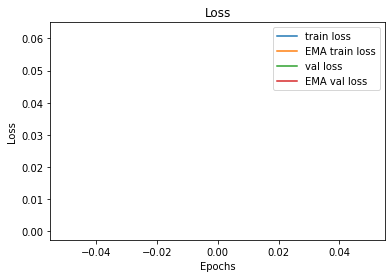

''

In [34]:
#del model1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Transformer(input_size=1,
        batch_first=False,
        d_model=512,  
        num_encoder_layers=4,
        num_decoder_layers=2,
        num_heads=8,
        dropout_encoder=0.1,
        dropout_decoder=0.1,
        ).to(device)


optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)  
#optimizer = torch.optim.SGD(model.parameters(), lr=0.0002)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.98)
criterion = torch.nn.MSELoss()

run_training(model=model, training_mode=2, EPOCH=10, input_length=30, 
             forecast_window= 100, label_length=1,  step=1,
             window_size=100, batch_size=32, 
             train_dataloader=train_dataloader_30_120,  test_dataloader=test_dataloader_30_120, 
             save_model=False, path_to_save_model="/content/save")


In [167]:
#@title INFERENCE
def inference2(model:Transformer, inference_mode:int, 
               idx: int, input_length:int, forecast_window:int,
               label_len:int, step:int, window_size:int,
               maa_index:int,train_datasetz,
               test_datasetz, train=True) -> Tensor:
  model.eval()
  assert maa_index-input_length >= 0, "Input length to big!"

  if train and idx < len(train_datasetz):
    print("train")
    _input = train_datasetz[idx]
  elif not train and idx < len(test_datasetz):
    print("test")
    _input = test_datasetz[idx]


  with torch.no_grad():
            if inference_mode == 1:
              """
              WHOLE PREDICTION IN ONE FORWARD PASS
              """
              source_begin = maa_index-input_length
              source_end = source_begin + input_length
              target_begin = source_end - label_len
              target_end = target_begin + label_len + forecast_window

              source = _input[source_begin:source_end].unsqueeze(-1).unsqueeze(-1).float().to(device)
              target = _input[target_begin:target_end].unsqueeze(-1).unsqueeze(-1).float().to(device)
              placeholder = torch.zeros(forecast_window, 1, 1).float().to(device)
  
              inp_target = torch.cat((source[label_len:,:,:], placeholder),dim=0)
              prediction = model(source, inp_target)
              
              prediction = prediction[-forecast_window:, 0, 0]
              data = _input[source_begin:target_end]
              print(prediction)
            
            elif inference_mode == 2:
              """
              MAKES SENSE FOR STEP not 1
              ENCODER INPUT MOVES ALONG PREDICTION, LABEL CHANGES ALSO
              DECODER INPUTS: LABEL -> LABEL'+1st OUTPUT -> LABEL''+1st+2nd OUTPUT....
              DECODER OUTPUTS: DECODER INPUTS SHIFTED BY STEP
              """
              prediction = []
              source_begin = maa_index - input_length
              source_end = source_begin + input_length
              target_in_begin = source_end - label_len 
              target_in_end = source_end 
  
              source = _input[source_begin:source_end].unsqueeze(-1).unsqueeze(-1).float().to(device)
              target_in = _input[target_in_begin:target_in_end].unsqueeze(-1).unsqueeze(-1).float().to(device)
                
              data = _input[0:source_end+forecast_window]
              for index in range(0, forecast_window, step):
                output = model(source, target_in)
                source = torch.cat((source[step:,:,:], output[-step:,:,:]), dim=0)
                target_in = torch.cat((target_in[:,:,:], output[-step:,:,:]), dim=0)

              prediction = output[-forecast_window:,0,0]
              print(prediction)

            elif inference_mode == 3:
              """
              ENCODER INPUT STAYS SAME
              DECODER INPUTS: LABEL -> LABEL+1st OUTPUT -> LABEL+1st+2nd OUTPUT....
              DECODER OUTPUTS: DECODER INPUTS SHIFTED BY STEP
              """
              source_begin = maa_index - input_length
              source_end = source_begin + input_length
              target_in_begin = source_end - label_len 
              target_in_end = source_end 
  
              source = _input[source_begin:source_end].unsqueeze(-1).unsqueeze(-1).float().to(device)
              target_in = _input[target_in_begin:target_in_end].unsqueeze(-1).unsqueeze(-1).float().to(device)

              data = _input[0:source_end+forecast_window]
              for index in range(0, forecast_window, step):
                
                output = model(source, target_in)
                target_in = torch.cat((target_in[:,:,:], output[-step:,:,:]), dim=0)

          
              prediction = torch.cat((_input[source_end].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1), output[-forecast_window+1:,:,:]),dim=0)
              prediction = prediction.view(-1)
            
              print(prediction)

            elif inference_mode == 4:
              """
              END IS NOT WHOLE OUTPUT BUT EVERY SINGLE STEP APPENDED
              ENCODER INPUT MOVES ALONG PREDICTION, LABEL CHANGES ALSO
              DECODER INPUTS: LABEL -> LABEL'+1st OUTPUT -> LABEL''+1st+2nd OUTPUT....
              DECODER OUTPUTS: DECODER INPUTS SHIFTED BY STEP
              """
              prediction = []
              source_begin = maa_index - input_length
              source_end = source_begin + input_length
              target_in_begin = source_end - label_len 
              target_in_end = source_end 
  
              source = _input[source_begin:source_end].unsqueeze(-1).unsqueeze(-1).float().to(device)
              target_in = _input[target_in_begin:target_in_end].unsqueeze(-1).unsqueeze(-1).float().to(device)
                
              data = _input[0:source_end+forecast_window]
              for index in range(0, forecast_window, step):

                output = model(source, target_in)
                source = torch.cat((source[step:,:,:], output[-step:,:,:]), dim=0)
                target_in = torch.cat((target_in[:,:,:], output[-step:,:,:]), dim=0)


                prediction.append(output[-step:,:,:].item())

              prediction = torch.FloatTensor(prediction)
              print(prediction)
             
  return  prediction.to("cpu"), data.to("cpu")

    

In [175]:
#@title plot



def plot_inference(model:Transformer, inference_mode:int, input_length: int,
         forecast_window: int,idx:int, label_len:int,
         step:int, window_size:int,maa_index:int,
         train_datasetz:Subset, test_datasetz:Subset, train: bool) -> None:
  
  if idx is None:
    if train:
        idx = random.randint(0, len(train_dataset))
    else:
        idx = random.randint(0, len(test_dataset))
        
  num_data_points = input_length +  forecast_window
  data_indx = [i for i in range(maa_index+forecast_window)]
  
  fig = plt.figure(figsize=(20, 5), dpi=80)
  fig.patch.set_facecolor((1.0, 1.0, 1.0))

  if train:
    scaler = load("scalar_item.joblib")
    prediction, data_price_train = inference2(model, inference_mode, idx, input_length, forecast_window,
                                              label_len, step, window_size, maa_index, train_datasetz, test_datasetz,
                                              train)
    #prediction = torch.cat((data_price_train,prediction[1:]),0)

    data_price_train_re = torch.from_numpy(scaler.inverse_transform(data_price_train.unsqueeze(-1)).squeeze(-1))
    
    to_plot_data_y_train_pred = np.zeros(maa_index +  forecast_window)
    to_plot_data_y_train_pred[maa_index: maa_index+forecast_window] = scaler.inverse_transform(prediction.unsqueeze(-1)).squeeze(-1)
    to_plot_data_y_train_pred = np.where(to_plot_data_y_train_pred == 0, None, to_plot_data_y_train_pred)
   
    plt.plot(data_indx, data_price_train_re, label="Actual prices (train)", color=config["plots"]["color_actual"])
    plt.plot(data_indx, to_plot_data_y_train_pred, label="Predicted prices (train)", color=config["plots"]["color_pred_train"])

  else:
    scaler = load("scalar_item.joblib")
    prediction, data_price_val = inference2(model, inference_mode, idx, input_length, forecast_window,
                                              label_len, step, window_size, maa_index, train_datasetz, test_datasetz,
                                              train)

    data_price_val_re = torch.from_numpy(scaler.inverse_transform(data_price_val.unsqueeze(-1)).squeeze(-1))
    
    to_plot_data_y_val_pred = np.zeros(maa_index +  forecast_window)
    to_plot_data_y_val_pred[maa_index: maa_index+forecast_window] = scaler.inverse_transform(prediction.unsqueeze(-1)).squeeze(-1)
    to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)

    plt.plot(data_indx, data_price_val_re, label="Actual prices (val)", color=config["plots"]["color_actual"])
    plt.plot(data_indx, to_plot_data_y_val_pred, label="Predicted prices (val)", color=config["plots"]["color_pred_val"])
  
  
  plt.title("Compare predicted prices to actual prices")
  xticks = [data_indx[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
  x = np.arange(0,len(xticks))
  plt.xticks(x, xticks, rotation='vertical')
  plt.grid(b=None, which='major', axis='y', linestyle='--')
  plt.legend()
  plt.show()



test
tensor([ 9.4796e-02,  7.3910e-02,  6.1821e-02,  4.8357e-02,  3.3438e-02,
         1.6914e-02, -1.3753e-03, -2.1670e-02, -4.7423e-02, -7.8444e-02,
        -1.1461e-01, -1.5581e-01, -2.0204e-01, -2.5425e-01, -3.1422e-01,
        -3.8248e-01, -4.5875e-01, -5.4195e-01, -6.3088e-01, -7.2285e-01,
        -8.1536e-01, -9.0519e-01, -9.8894e-01, -1.0666e+00, -1.1375e+00,
        -1.2006e+00, -1.2547e+00, -1.2994e+00, -1.3348e+00, -1.3621e+00,
        -1.3819e+00, -1.3957e+00, -1.4047e+00, -1.4099e+00, -1.4122e+00,
        -1.4123e+00, -1.4108e+00, -1.4081e+00, -1.4047e+00, -1.4007e+00,
        -1.3965e+00, -1.3921e+00, -1.3877e+00, -1.3834e+00, -1.3793e+00,
        -1.3753e+00, -1.3715e+00, -1.3680e+00, -1.3648e+00, -1.3618e+00,
        -1.3592e+00, -1.3569e+00, -1.3548e+00, -1.3530e+00, -1.3515e+00,
        -1.3501e+00, -1.3490e+00, -1.3481e+00, -1.3474e+00, -1.3468e+00,
        -1.3463e+00, -1.3460e+00, -1.3458e+00, -1.3457e+00, -1.3457e+00,
        -1.3457e+00, -1.3459e+00, -1.3461e+00,

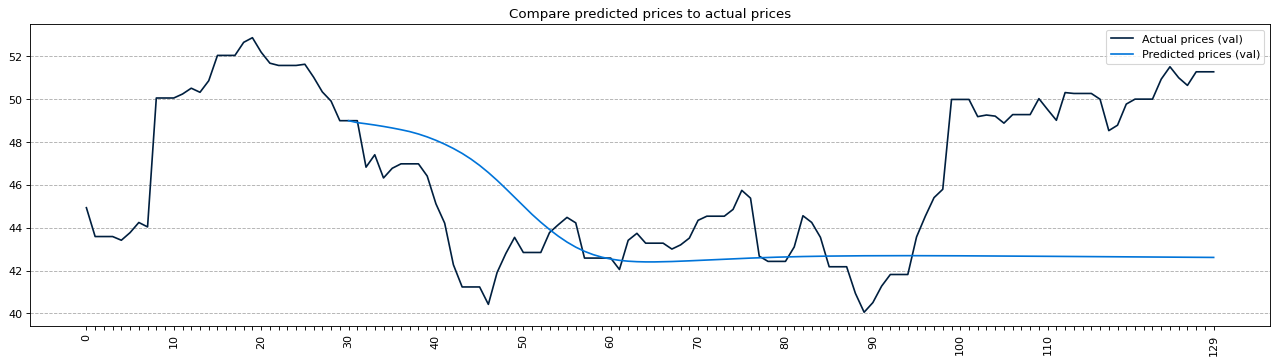

In [195]:
plot_inference(model=model, inference_mode=3, input_length=30,
     forecast_window=100, idx=None, label_len=1, maa_index = 30,
     step=1, window_size=100,
     train_datasetz=train_dataset_100_100, test_datasetz=test_dataset_100_100,
     train=False)


In [ ]:
#STATISTICAL ANALYSIS

In [ ]:
#@title TRANSFORMER2


"""class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()       
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
      return x + self.pe[:x.size(0), :]
    """
"""
POSITIONAL ENCODING TAKES   [SEQ_LEN, BATCH_SIZE, FEATURE_SIZE = 1]
                    RETURNS [SEQ_LEN, BATCH_SIZE, EMBED_DIM]
TRANSFORMER         TAKES   [SEQ_LEN, BATCH_SIZE, EMBED_DIM]
                    RETURNS [SEQ_LEN, BATCH_SIZE, FEATURE_SIZE = 1]
"""

"""
tau: time
F: periodic function
w_i, phi_i learnable parameters
t2v(tau) = (w_i*tau + phi_i)    if i=0
           (F(w_i*tau + phi_i))  for 1<=i<=k
-> k+1 -dimensional vector


"""
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()       
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        #pe.requires_grad = False
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

class Time2Vec(nn.Module):
  def __init__(self, embed_dimension, device):
    super(Time2Vec, self).__init__()
    self.embed_dimension = embed_dimension
    self.w_0 = nn.parameter.Parameter(torch.randn(1))
    self.phi_0 = nn.parameter.Parameter(torch.randn(1))
    self.w = nn.parameter.Parameter(torch.randn(embed_dimension-1))
    self.phi = nn.parameter.Parameter(torch.randn(embed_dimension-1))
    self.F = torch.sin
    self.device = device


  def forward(self, src):
    """
    ARGS: src [SEQUENCE_LENGTH, BATCH_SIZE, FEATURE_SIZE]  
    OUT:      [SEQUENCE_LENGTH, EMBED DIMENSION] 
    """
    sequence_length = src.shape[0]
    batch_size = src.shape[1]
    tau = torch.arange(0,sequence_length).to(device)
    v_0 =  self.w_0 * tau + self.phi_0    
    v_1 = torch.einsum("i,j -> ij", tau, self.w) + self.phi
    W_pos = torch.cat((v_0.unsqueeze(-1), self.F(v_1)), -1) 
    
    W_pos = W_pos.unsqueeze(1)   #SHAPE [SEQUENCE_LENGTH,1, EMBED DIMENSION] 
    W_pos = W_pos.expand(sequence_length, batch_size, -1)
    return W_pos   #SHAPE [SEQUENCE_LENGTH, BATCH_SIZE, EMBED DIMENSION] 

class Embedding(nn.Module):
  def __init__(self, feature_size, embed_dimension):
    super(Embedding, self).__init__()
    self.feature_size = feature_size
    self.embed_dimension = embed_dimension

    self.w_p = nn.parameter.Parameter(torch.randn(embed_dimension, feature_size))
    self.b_p = nn.parameter.Parameter(torch.randn(embed_dimension))


  def forward(self, src):
    """"
    ARGS: src [SEQUENCE_LENGTH, BATCH_SIZE, FEATURE_SIZE]
    OUTPUT:   [SEQUENCE_LENGTH, BATCH_SIZE, EMBED_DIMENSION]
    """
    return torch.einsum("ij, kbj -> kbi", self.w_p, src) + self.b_p

class DataEmbedding(nn.Module):
    def __init__(self, c_in, d_model, embed_type='fixed', freq='h', dropout=0.1):
        super(DataEmbedding, self).__init__()

        self.value_embedding = TokenEmbedding(c_in=c_in, d_model=d_model)
        self.position_embedding = PositionalEmbedding(d_model=d_model)
        self.temporal_embedding = TemporalEmbedding(d_model=d_model, embed_type=embed_type,
                                                    freq=freq) if embed_type != 'timeF' else TimeFeatureEmbedding(
            d_model=d_model, embed_type=embed_type, freq=freq)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, x_mark):
        x = self.value_embedding(x) + self.temporal_embedding(x_mark) + self.position_embedding(x)
        return self.dropout(x)

class Transformer2(nn.Module):
    # d_model : number of features - embed-dimnesion
    def __init__(
        self, 
        feature_size: int,
        dim_model:int,
        num_heads: int, 
        num_encoder_layers: int,
        num_decoder_layers: int,
        dropout:float,
        device) -> None:

        super(Transformer2, self).__init__()

        self.model_type = 'Transformer'
        self.device = device
        self.feature_size = feature_size
        self.dim_model = dim_model

        self.num_heads = num_heads
        self.num_encoder_layers = num_encoder_layers
        self.num_decoder_layers = num_decoder_layers
        #self.value_embedding = TokenEmbedding(d_model=d_model)
        #self.embedding = Embedding(feature_size, dim_model)
        self.embedding = nn.Linear(feature_size,dim_model)
        #self.positional_encoder = Time2Vec(dim_model, device)
        self.positional_encoder = PositionalEncoding(dim_model)
        self.transformer = nn.Transformer(
            d_model=dim_model,
            nhead=num_heads,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dropout=dropout,
            activation="gelu"
        )#activation="relu"
      
        self.out = nn.Linear(dim_model, 1)
      
    def init_weights(self) -> None:
        initrange = 0.5
        #self.decoder.bias.data.zero_()
        #self.decoder.weight.data.uniform_(-initrange, initrange)
        #self.embedding.weight.data.uniform_(-initrange, initrange)
        torch.nn.init.xavier_uniform_(self.decoder.weight.data)
        torch.nn.init.xavier_uniform_(self.embedding.weight.data)

    def _generate_square_subsequent_mask(self, sz: int) -> torch.Tensor:
        return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)
    """
    tensor([[0., -inf, -inf],
           [0., 0., -inf],
           [0., 0., 0.]])
    """
#trg
    def forward(self, src, tgt, trg_mask=None, src_mask=None):
        """
        ARGS: sequence [SEQUENCE_LENGTH, BATCH_SIZE, FEATURE_SIZE]
        OUT: [SEQUENCE_LENGTH, BATCH_SIZE, FEATURE_SIZE]   
        """
        src = self.embedding(src) * math.sqrt(self.dim_model)
        tgt = self.embedding(tgt) * math.sqrt(self.dim_model)
        src = src + self.positional_encoder(src)
        tgt = tgt + self.positional_encoder(tgt)

        transformer_out = self.transformer(src, tgt, tgt_mask=trg_mask, src_mask = src_mask)
        out = self.out(transformer_out)
        return out
